In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

## Loading and utils

In [13]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")
    
    #print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def prepare_data(papier):
    
    if 'mst' in papier:
        df = pd.read_csv(f'data/{papier}')
    else:    
        df = pd.read_csv(f'data/{papier}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

def prepare_index(indeks):
    
    if 'mst' in indeks:
        df = pd.read_csv(f'data_for/{indeks}')
    else:    
        df = pd.read_csv(f'data_for/{indeks}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

In [9]:
update_indexes()

In [12]:
update_stocks()

Updated 2020-04-11, max actual date: 2020-04-09 00:00:00


In [16]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}')

no of all available stock: 1957 and indexes: 23


## Single plot

In [17]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [18]:
all_indekses

['SASESLCT.mst',
 'NIKKEI.mst',
 'HANGSENG.mst',
 'DAX.mst',
 'BOVESPA.mst',
 'BUENOS.mst',
 'DJIA.mst',
 'FT-SE100.mst',
 'MEXICIPC.mst',
 'ALL_ORD.mst',
 'TSE-300.mst',
 'SMI.mst',
 'EOE.mst',
 'SP500.mst',
 'BUX.mst',
 'DJTA.mst',
 'DJUA.mst',
 'AMEX_MAJ.mst',
 'RUSSEL.mst',
 'NASDAQ.mst',
 'B-SHARES.mst',
 'TOPIX.mst',
 'CAC40.mst']

In [19]:
df = prepare_index('NIKKEI')

In [20]:
df.tail()

,TICKER,OPEN,HIGH,LOW,CLOSE,VOL
DTYYYYMMDD,,,,,,
2020-04-03,NIKKEI,17951.44,18059.15,17646.50,17820.19,0
2020-04-06,NIKKEI,17857.99,18672.26,17802.62,18576.30,0
2020-04-07,NIKKEI,18878.86,19162.52,18553.14,18950.18,0
2020-04-08,NIKKEI,19047.76,19454.34,18730.80,19353.24,0
2020-04-09,NIKKEI,19376.00,19406.96,19158.55,19345.77,0


In [7]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [8]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

## One one paper

In [61]:
[a for a in all_files if 'MOB' in a]

['IMMOBILE.mst']

In [62]:
papier = 'NEUCA'

In [63]:
#plot_paper(papier,'2008-07-15','2008-11-15')

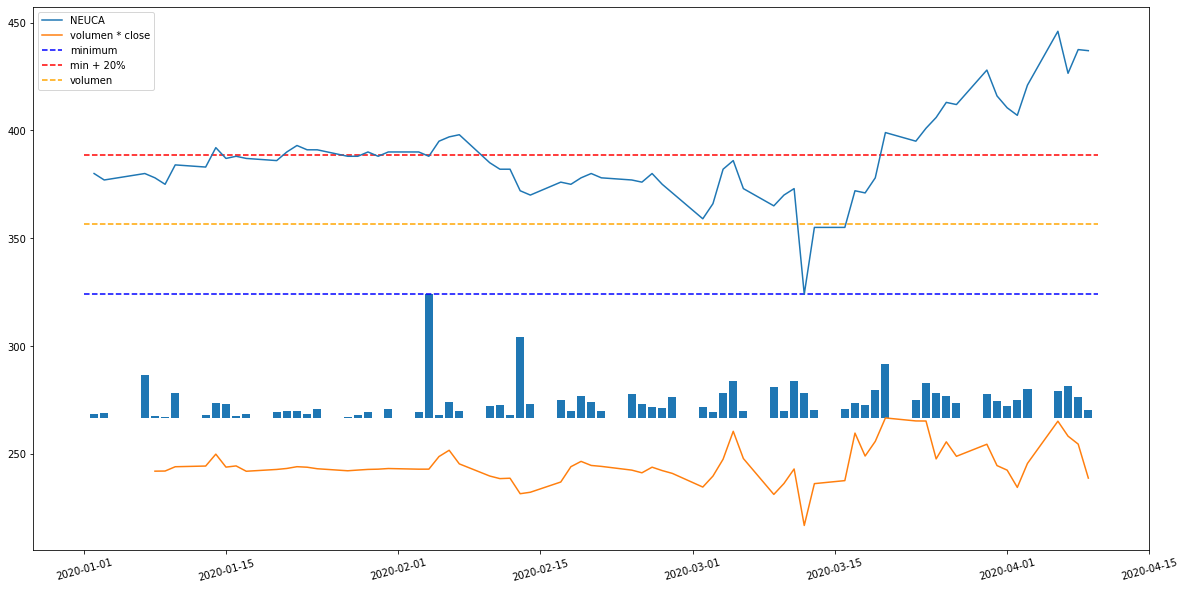

In [66]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [67]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [68]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: NEUCA, currently at 437.0, with potential -8.92% to top
Max before crisis: 398.0
Crisis bottom: 324.0
Max after crisis drop: 446.0, at 2020-04-06 00:00:00
Stats after Max: [446.  426.5 437.5 437. ]


## Skaner

In [9]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [10]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_files):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1957/1957 [00:11<00:00, 165.52it/s]


In [11]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [65]:
skaner_df_see = skaner_df.loc[
#     (skaner_df.growth_quarter > 0) 
#         & (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        (skaner_df.growth_current > 20)
                              ,:].sort_values('drop_current', ascending=True)

In [77]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [79]:
skaner_df_see.tail(100)

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,VOTUM,11.000,14.100,11.4000,8.1800,8.200,11.250,14.950,23.68,39.36,37.20,34.15,35.91,-26.42
0,FERRO,13.500,17.250,13.7000,13.9000,10.300,13.500,18.250,25.91,-1.44,31.07,31.07,35.19,-26.03
0,DIGITREE,4.440,4.900,NaN,NaN,3.400,4.480,6.000,NaN,NaN,31.76,30.59,35.14,-26.00
0,RADPOL,1.170,1.455,1.1400,1.4150,0.940,1.180,1.580,27.63,-19.43,25.53,24.47,35.04,-25.95
0,WIRTUALNA,64.000,84.600,66.8000,58.0000,47.400,64.000,86.400,26.65,15.17,35.02,35.02,35.00,-25.93
0,DECORA,14.900,19.700,17.5000,18.1000,11.900,16.000,20.000,12.57,-3.31,34.45,25.21,34.23,-25.50
0,ADIUVO,5.740,6.300,7.3000,8.2600,4.700,7.260,7.700,-13.70,-11.62,54.47,22.13,34.15,-25.45
0,TORPOL,6.640,8.900,6.8800,6.9600,5.000,6.900,8.900,29.36,-1.15,38.00,32.80,34.04,-25.39
0,POLICE,10.600,10.500,NaN,14.5000,7.100,10.600,14.200,NaN,NaN,49.30,49.30,33.96,-25.35
0,VIVID,1.312,1.714,1.3000,1.4400,0.980,1.438,1.750,31.85,-9.72,46.73,33.88,33.38,-25.03


### WIG

In [84]:
skaner_wig_df = pd.DataFrame(columns=df_cols)
for w in tqdm([a for a in all_files if 'WIG' in a]):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_wig_df = pd.concat([skaner_wig_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 50/50 [00:00<00:00, 141.45it/s]


In [85]:
skaner_wig_df.loc[:,'growth_quarter'] = round(skaner_wig_df.loc[:,'before_crisis'] * 100 / skaner_wig_df.loc[:,'last_y_q'] - 100, 2)
skaner_wig_df.loc[:,'growth_mid'] = round(skaner_wig_df.loc[:,'last_y_q'] * 100 / skaner_wig_df.loc[:,'last_y_mid'] - 100, 2)
skaner_wig_df.loc[:,'growth_from_crisis'] = round(skaner_wig_df.loc[:,'max_after_crisis'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'growth_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'drop_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'max_before_crisis'] - 100, 2)


In [63]:
skaner_wig_df_see = skaner_wig_df.loc[
    (skaner_wig_df.growth_quarter > 0) & 
         (skaner_wig_df.growth_mid > 0) & 
          (skaner_wig_df.drop_current < -15) &
          (skaner_wig_df.growth_current > 10),:].sort_values('drop_current', ascending=True)

In [87]:
skaner_wig_df.sort_values('growth_current')

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,RCLMWIG40AOPEN,29.15,NaN,NaN,NaN,29.15,29.15,39.31,NaN,NaN,0.00,0.00,-25.85
0,SWIG80DVP,0.94,NaN,371.67,97.65,0.94,0.94,410.71,NaN,280.61,0.00,0.00,-99.77
0,WIG-BANKI,3931.74,6852.02,7073.65,7513.37,3931.74,4406.52,7327.60,-3.13,-5.85,12.08,0.00,-46.34
0,MWIG40DVP,0.57,0.57,110.86,38.96,0.57,0.57,117.22,-99.49,184.55,0.00,0.00,-99.51
0,WIG-NRCHOM,1834.45,2610.21,2288.28,2110.54,1834.45,2132.56,2610.21,14.07,8.42,16.25,0.00,-29.72
0,RCBMWIG401121,748.10,NaN,NaN,NaN,748.10,748.10,1005.60,NaN,NaN,0.00,0.00,-25.61
0,RCFS2MWIG40,20.29,NaN,NaN,NaN,20.29,20.29,NaN,NaN,NaN,0.00,0.00,NaN
0,WIG20SHORT,4943.90,3696.44,3633.11,3490.73,4925.06,5623.80,3826.33,1.74,4.08,14.19,0.38,29.21
0,WIG.MS-FIN,6130.43,10041.71,10343.27,11200.03,6047.16,6612.93,10700.18,-2.92,-7.65,9.36,1.38,-42.71
0,MWIG40TR,3722.18,5299.43,4779.99,5029.64,3603.52,3869.21,5339.13,10.87,-4.96,7.37,3.29,-30.28


## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

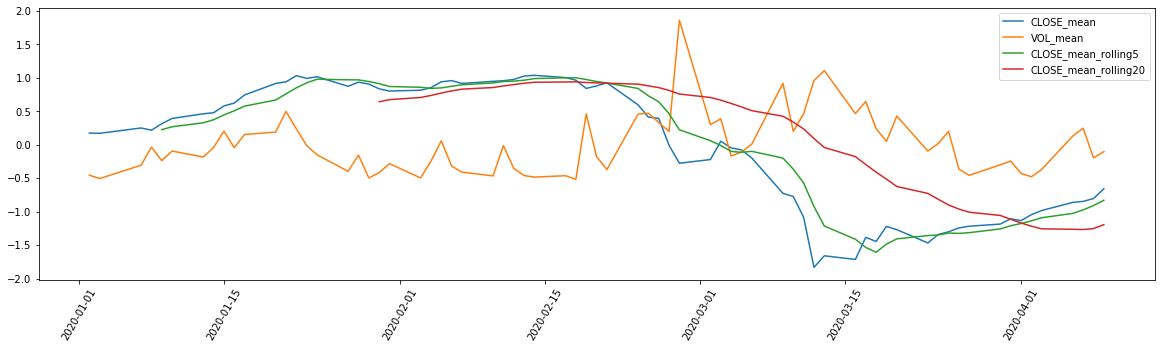

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [17]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

In [55]:
def transform_one_paper(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    #df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    df.loc[:, 'target'] = np.nan
    df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
    df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    return df

In [258]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'chng_OPEN_CLOSE'] = (df.loc[:,'CLOSE'] * 100 / df.loc[:,'OPEN']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
       
    df.loc[df.loc[:, 'LOW'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 1
    df.loc[df.loc[:, 'LOW'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 0
    
    df.loc[df.loc[:, 'HIGH'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 0
    
    df.loc[df.loc[:, 'OPEN'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 0
    
    df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    df.loc[df.loc[:, 'CLOSE'] > df.loc[:, 'OPEN'],'comp_CLOSE_OPEN'] = 1
    df.loc[df.loc[:, 'CLOSE'] <= df.loc[:, 'OPEN'],'comp_CLOSE_OPEN'] = 0
    
    df.loc[:,'same_CLOSE_LOW'] = 0
    df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'LOW'],'same_CLOSE_LOW'] = 1
    df.loc[:,'same_CLOSE_HIGH'] = 0
    df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'HIGH'],'same_CLOSE_HIGH'] = 1
    
    df.loc[:,'same_OPEN_LOW'] = 0
    df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'LOW'],'same_OPEN_LOW'] = 1
    df.loc[:,'same_OPEN_HIGH'] = 0
    df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'HIGH'],'same_OPEN_HIGH'] = 1
    
    
    #future
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0

    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
    #historic features

#     for a in [c for c in df.columns if ('chng_' in c) | ('move_' in c) | ('comp_' in c)]:
#         for i in [1, 2, 3, 4, 5]:
#             df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('comp_' in c) 
                                        | ('diff_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()


#     df.loc[:, 'target'] = df.loc[:, 'chng_rel_OPEN'].shift(-1)
#    df.loc[:,'target'] = df.loc[:,'comp_CLOSE_OPEN'].shift(-1)
    df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0
    
#df.loc[:, 'target'] = df.loc[:,'diff_LOW_HIGH'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0

#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'], 'target'] = 0
    
#     df.loc[:, 'target'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target'] = df.loc[:, 'chng_OPEN'].shift(-1)
#     df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    return df

In [251]:
#store_dict = dict()

In [252]:
counter = 0
df_merged = pd.DataFrame()

if 'store_dict' not in locals():
    store_dict = dict()

for p in tqdm(skaner_df_see.ticker.values):
    
    try:
        df = store_dict[p].copy()
        
    except:
        df = prepare_data(p) 
        store_dict[p] = df.copy()
        counter = counter + 1
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


In [274]:
df = df_merged.copy()

#df_merged.loc[:, ['TICKER','bin_OPEN']].iloc[125:200,:].groupby('TICKER').shift(1)
#df_merged.loc[:, 'target'] = df_merged.loc[:, 'bin_OPEN'].shift(-1)

In [275]:
train_cols = [c for c in df.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c)]

In [276]:
#train_cols = train_cols_limited

cut_date = '2020-01-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [277]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')

# # # Initialize CatBoostClassifier
# model = CatBoostRegressor(iterations=2000,
#                            learning_rate=0.05,
#                            depth=3,
#                           thread_count=4,
#                           eval_metric='RMSE')

In [278]:
model.fit(train_data, train_labels, 
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.7536311	test: 0.7666588	best: 0.7666588 (0)	total: 8.66ms	remaining: 1m 26s
1:	learn: 0.7549918	test: 0.7683763	best: 0.7683763 (1)	total: 17.3ms	remaining: 1m 26s
2:	learn: 0.7715977	test: 0.7727464	best: 0.7727464 (2)	total: 25.7ms	remaining: 1m 25s
3:	learn: 0.7748268	test: 0.7778034	best: 0.7778034 (3)	total: 34.6ms	remaining: 1m 26s
4:	learn: 0.7847955	test: 0.7865488	best: 0.7865488 (4)	total: 50.4ms	remaining: 1m 40s
5:	learn: 0.7859122	test: 0.7868732	best: 0.7868732 (5)	total: 59ms	remaining: 1m 38s
6:	learn: 0.7855357	test: 0.7888679	best: 0.7888679 (6)	total: 68.1ms	remaining: 1m 37s
7:	learn: 0.7859394	test: 0.7896354	best: 0.7896354 (7)	total: 76.5ms	remaining: 1m 35s
8:	learn: 0.7864356	test: 0.7906611	best: 0.7906611 (8)	total: 85ms	remaining: 1m 34s
9:	learn: 0.7872193	test: 0.7913770	best: 0.7913770 (9)	total: 93.6ms	remaining: 1m 33s
10:	learn: 0.7871661	test: 0.7917372	best: 0.7917372 (10)	total: 106ms	remaining: 1m 36s
11:	learn: 0.7885693	test: 0.792416

110:	learn: 0.8169073	test: 0.8149829	best: 0.8149829 (110)	total: 1.03s	remaining: 1m 31s
111:	learn: 0.8169433	test: 0.8149736	best: 0.8149829 (110)	total: 1.03s	remaining: 1m 31s
112:	learn: 0.8169886	test: 0.8150481	best: 0.8150481 (112)	total: 1.04s	remaining: 1m 31s
113:	learn: 0.8170327	test: 0.8151604	best: 0.8151604 (113)	total: 1.05s	remaining: 1m 31s
114:	learn: 0.8170896	test: 0.8151566	best: 0.8151604 (113)	total: 1.06s	remaining: 1m 31s
115:	learn: 0.8171711	test: 0.8153391	best: 0.8153391 (115)	total: 1.07s	remaining: 1m 31s
116:	learn: 0.8172676	test: 0.8154217	best: 0.8154217 (116)	total: 1.08s	remaining: 1m 31s
117:	learn: 0.8173623	test: 0.8155176	best: 0.8155176 (117)	total: 1.09s	remaining: 1m 31s
118:	learn: 0.8174486	test: 0.8156170	best: 0.8156170 (118)	total: 1.1s	remaining: 1m 31s
119:	learn: 0.8175365	test: 0.8157495	best: 0.8157495 (119)	total: 1.11s	remaining: 1m 31s
120:	learn: 0.8176214	test: 0.8158049	best: 0.8158049 (120)	total: 1.11s	remaining: 1m 30s


201:	learn: 0.8218773	test: 0.8216675	best: 0.8216675 (201)	total: 1.84s	remaining: 1m 29s
202:	learn: 0.8219193	test: 0.8216452	best: 0.8216675 (201)	total: 1.85s	remaining: 1m 29s
203:	learn: 0.8219602	test: 0.8216889	best: 0.8216889 (203)	total: 1.86s	remaining: 1m 29s
204:	learn: 0.8219900	test: 0.8217680	best: 0.8217680 (204)	total: 1.86s	remaining: 1m 29s
205:	learn: 0.8220211	test: 0.8218244	best: 0.8218244 (205)	total: 1.87s	remaining: 1m 29s
206:	learn: 0.8220377	test: 0.8218673	best: 0.8218673 (206)	total: 1.88s	remaining: 1m 29s
207:	learn: 0.8220758	test: 0.8218794	best: 0.8218794 (207)	total: 1.89s	remaining: 1m 29s
208:	learn: 0.8221186	test: 0.8219289	best: 0.8219289 (208)	total: 1.9s	remaining: 1m 29s
209:	learn: 0.8221706	test: 0.8219630	best: 0.8219630 (209)	total: 1.91s	remaining: 1m 29s
210:	learn: 0.8222069	test: 0.8219540	best: 0.8219630 (209)	total: 1.92s	remaining: 1m 28s
211:	learn: 0.8222465	test: 0.8220043	best: 0.8220043 (211)	total: 1.92s	remaining: 1m 28s


297:	learn: 0.8248017	test: 0.8260560	best: 0.8260560 (297)	total: 2.85s	remaining: 1m 32s
298:	learn: 0.8248212	test: 0.8260808	best: 0.8260808 (298)	total: 2.86s	remaining: 1m 32s
299:	learn: 0.8248421	test: 0.8261641	best: 0.8261641 (299)	total: 2.88s	remaining: 1m 33s
300:	learn: 0.8248563	test: 0.8261955	best: 0.8261955 (300)	total: 2.89s	remaining: 1m 33s
301:	learn: 0.8248830	test: 0.8262467	best: 0.8262467 (301)	total: 2.9s	remaining: 1m 33s
302:	learn: 0.8249043	test: 0.8263148	best: 0.8263148 (302)	total: 2.91s	remaining: 1m 33s
303:	learn: 0.8249170	test: 0.8263531	best: 0.8263531 (303)	total: 2.92s	remaining: 1m 33s
304:	learn: 0.8249429	test: 0.8263656	best: 0.8263656 (304)	total: 2.93s	remaining: 1m 33s
305:	learn: 0.8249610	test: 0.8263738	best: 0.8263738 (305)	total: 2.94s	remaining: 1m 33s
306:	learn: 0.8249733	test: 0.8263941	best: 0.8263941 (306)	total: 2.96s	remaining: 1m 33s
307:	learn: 0.8249970	test: 0.8264146	best: 0.8264146 (307)	total: 2.98s	remaining: 1m 33s


391:	learn: 0.8266011	test: 0.8287440	best: 0.8287440 (391)	total: 4.72s	remaining: 1m 55s
392:	learn: 0.8266171	test: 0.8287588	best: 0.8287588 (392)	total: 4.75s	remaining: 1m 56s
393:	learn: 0.8266351	test: 0.8287907	best: 0.8287907 (393)	total: 4.79s	remaining: 1m 56s
394:	learn: 0.8266615	test: 0.8288381	best: 0.8288381 (394)	total: 4.8s	remaining: 1m 56s
395:	learn: 0.8266848	test: 0.8288684	best: 0.8288684 (395)	total: 4.82s	remaining: 1m 56s
396:	learn: 0.8266907	test: 0.8288904	best: 0.8288904 (396)	total: 4.85s	remaining: 1m 57s
397:	learn: 0.8267179	test: 0.8289575	best: 0.8289575 (397)	total: 4.88s	remaining: 1m 57s
398:	learn: 0.8267332	test: 0.8289700	best: 0.8289700 (398)	total: 4.9s	remaining: 1m 58s
399:	learn: 0.8267553	test: 0.8289872	best: 0.8289872 (399)	total: 4.93s	remaining: 1m 58s
400:	learn: 0.8267741	test: 0.8290381	best: 0.8290381 (400)	total: 4.96s	remaining: 1m 58s
401:	learn: 0.8267875	test: 0.8291436	best: 0.8291436 (401)	total: 4.98s	remaining: 1m 59s
4

490:	learn: 0.8279036	test: 0.8310559	best: 0.8310559 (490)	total: 7.03s	remaining: 2m 16s
491:	learn: 0.8279118	test: 0.8310716	best: 0.8310716 (491)	total: 7.05s	remaining: 2m 16s
492:	learn: 0.8279260	test: 0.8310850	best: 0.8310850 (492)	total: 7.07s	remaining: 2m 16s
493:	learn: 0.8279318	test: 0.8311139	best: 0.8311139 (493)	total: 7.09s	remaining: 2m 16s
494:	learn: 0.8279432	test: 0.8311003	best: 0.8311139 (493)	total: 7.11s	remaining: 2m 16s
495:	learn: 0.8279538	test: 0.8311170	best: 0.8311170 (495)	total: 7.13s	remaining: 2m 16s
496:	learn: 0.8279611	test: 0.8311262	best: 0.8311262 (496)	total: 7.15s	remaining: 2m 16s
497:	learn: 0.8279675	test: 0.8311326	best: 0.8311326 (497)	total: 7.17s	remaining: 2m 16s
498:	learn: 0.8279774	test: 0.8311282	best: 0.8311326 (497)	total: 7.19s	remaining: 2m 16s
499:	learn: 0.8279871	test: 0.8311120	best: 0.8311326 (497)	total: 7.21s	remaining: 2m 16s
500:	learn: 0.8280032	test: 0.8311478	best: 0.8311478 (500)	total: 7.22s	remaining: 2m 16s

584:	learn: 0.8288629	test: 0.8322970	best: 0.8322970 (584)	total: 8.71s	remaining: 2m 20s
585:	learn: 0.8288678	test: 0.8322970	best: 0.8322970 (584)	total: 8.72s	remaining: 2m 20s
586:	learn: 0.8288839	test: 0.8323230	best: 0.8323230 (586)	total: 8.74s	remaining: 2m 20s
587:	learn: 0.8288992	test: 0.8323570	best: 0.8323570 (587)	total: 8.75s	remaining: 2m 20s
588:	learn: 0.8289081	test: 0.8323603	best: 0.8323603 (588)	total: 8.77s	remaining: 2m 20s
589:	learn: 0.8289187	test: 0.8323518	best: 0.8323603 (588)	total: 8.79s	remaining: 2m 20s
590:	learn: 0.8289270	test: 0.8323735	best: 0.8323735 (590)	total: 8.82s	remaining: 2m 20s
591:	learn: 0.8289369	test: 0.8323815	best: 0.8323815 (591)	total: 8.85s	remaining: 2m 20s
592:	learn: 0.8289462	test: 0.8324352	best: 0.8324352 (592)	total: 8.87s	remaining: 2m 20s
593:	learn: 0.8289601	test: 0.8324468	best: 0.8324468 (593)	total: 8.89s	remaining: 2m 20s
594:	learn: 0.8289771	test: 0.8324651	best: 0.8324651 (594)	total: 8.91s	remaining: 2m 20s

681:	learn: 0.8297135	test: 0.8339040	best: 0.8339040 (681)	total: 10.4s	remaining: 2m 21s
682:	learn: 0.8297235	test: 0.8339265	best: 0.8339265 (682)	total: 10.4s	remaining: 2m 21s
683:	learn: 0.8297310	test: 0.8339516	best: 0.8339516 (683)	total: 10.4s	remaining: 2m 21s
684:	learn: 0.8297445	test: 0.8339630	best: 0.8339630 (684)	total: 10.4s	remaining: 2m 21s
685:	learn: 0.8297508	test: 0.8339729	best: 0.8339729 (685)	total: 10.4s	remaining: 2m 21s
686:	learn: 0.8297660	test: 0.8340172	best: 0.8340172 (686)	total: 10.4s	remaining: 2m 21s
687:	learn: 0.8297725	test: 0.8340601	best: 0.8340601 (687)	total: 10.5s	remaining: 2m 21s
688:	learn: 0.8297778	test: 0.8340627	best: 0.8340627 (688)	total: 10.5s	remaining: 2m 21s
689:	learn: 0.8297800	test: 0.8340570	best: 0.8340627 (688)	total: 10.5s	remaining: 2m 21s
690:	learn: 0.8297870	test: 0.8340508	best: 0.8340627 (688)	total: 10.5s	remaining: 2m 21s
691:	learn: 0.8298003	test: 0.8340688	best: 0.8340688 (691)	total: 10.5s	remaining: 2m 21s

781:	learn: 0.8304639	test: 0.8348906	best: 0.8348906 (781)	total: 12s	remaining: 2m 21s
782:	learn: 0.8304709	test: 0.8349084	best: 0.8349084 (782)	total: 12.1s	remaining: 2m 21s
783:	learn: 0.8304806	test: 0.8349256	best: 0.8349256 (783)	total: 12.1s	remaining: 2m 21s
784:	learn: 0.8304860	test: 0.8349134	best: 0.8349256 (783)	total: 12.1s	remaining: 2m 21s
785:	learn: 0.8304923	test: 0.8349072	best: 0.8349256 (783)	total: 12.1s	remaining: 2m 21s
786:	learn: 0.8305033	test: 0.8349315	best: 0.8349315 (786)	total: 12.1s	remaining: 2m 21s
787:	learn: 0.8305104	test: 0.8349314	best: 0.8349315 (786)	total: 12.1s	remaining: 2m 21s
788:	learn: 0.8305192	test: 0.8349628	best: 0.8349628 (788)	total: 12.2s	remaining: 2m 21s
789:	learn: 0.8305250	test: 0.8349776	best: 0.8349776 (789)	total: 12.2s	remaining: 2m 21s
790:	learn: 0.8305305	test: 0.8349950	best: 0.8349950 (790)	total: 12.2s	remaining: 2m 21s
791:	learn: 0.8305360	test: 0.8349968	best: 0.8349968 (791)	total: 12.2s	remaining: 2m 21s
7

882:	learn: 0.8310869	test: 0.8357726	best: 0.8357726 (882)	total: 13.7s	remaining: 2m 21s
883:	learn: 0.8310923	test: 0.8357686	best: 0.8357726 (882)	total: 13.7s	remaining: 2m 21s
884:	learn: 0.8310959	test: 0.8357707	best: 0.8357726 (882)	total: 13.7s	remaining: 2m 21s
885:	learn: 0.8311003	test: 0.8357710	best: 0.8357726 (882)	total: 13.7s	remaining: 2m 21s
886:	learn: 0.8311033	test: 0.8357585	best: 0.8357726 (882)	total: 13.7s	remaining: 2m 21s
887:	learn: 0.8311068	test: 0.8357828	best: 0.8357828 (887)	total: 13.7s	remaining: 2m 21s
888:	learn: 0.8311105	test: 0.8358043	best: 0.8358043 (888)	total: 13.8s	remaining: 2m 21s
889:	learn: 0.8311196	test: 0.8358241	best: 0.8358241 (889)	total: 13.8s	remaining: 2m 21s
890:	learn: 0.8311234	test: 0.8358255	best: 0.8358255 (890)	total: 13.8s	remaining: 2m 21s
891:	learn: 0.8311284	test: 0.8358380	best: 0.8358380 (891)	total: 13.8s	remaining: 2m 21s
892:	learn: 0.8311360	test: 0.8358595	best: 0.8358595 (892)	total: 13.8s	remaining: 2m 21s

973:	learn: 0.8315641	test: 0.8363850	best: 0.8363850 (973)	total: 15.1s	remaining: 2m 19s
974:	learn: 0.8315741	test: 0.8364053	best: 0.8364053 (974)	total: 15.1s	remaining: 2m 19s
975:	learn: 0.8315810	test: 0.8364016	best: 0.8364053 (974)	total: 15.1s	remaining: 2m 19s
976:	learn: 0.8315850	test: 0.8363995	best: 0.8364053 (974)	total: 15.1s	remaining: 2m 19s
977:	learn: 0.8315874	test: 0.8363917	best: 0.8364053 (974)	total: 15.2s	remaining: 2m 19s
978:	learn: 0.8315943	test: 0.8363963	best: 0.8364053 (974)	total: 15.2s	remaining: 2m 19s
979:	learn: 0.8315983	test: 0.8364440	best: 0.8364440 (979)	total: 15.2s	remaining: 2m 19s
980:	learn: 0.8316032	test: 0.8364442	best: 0.8364442 (980)	total: 15.2s	remaining: 2m 19s
981:	learn: 0.8316067	test: 0.8364480	best: 0.8364480 (981)	total: 15.2s	remaining: 2m 19s
982:	learn: 0.8316126	test: 0.8364897	best: 0.8364897 (982)	total: 15.3s	remaining: 2m 20s
983:	learn: 0.8316203	test: 0.8365033	best: 0.8365033 (983)	total: 15.3s	remaining: 2m 20s

1062:	learn: 0.8319632	test: 0.8369522	best: 0.8369523 (1061)	total: 16.7s	remaining: 2m 20s
1063:	learn: 0.8319661	test: 0.8369689	best: 0.8369689 (1063)	total: 16.8s	remaining: 2m 20s
1064:	learn: 0.8319679	test: 0.8369707	best: 0.8369707 (1064)	total: 16.8s	remaining: 2m 20s
1065:	learn: 0.8319714	test: 0.8369997	best: 0.8369997 (1065)	total: 16.8s	remaining: 2m 20s
1066:	learn: 0.8319731	test: 0.8369932	best: 0.8369997 (1065)	total: 16.8s	remaining: 2m 20s
1067:	learn: 0.8319779	test: 0.8370324	best: 0.8370324 (1067)	total: 16.8s	remaining: 2m 20s
1068:	learn: 0.8319795	test: 0.8370312	best: 0.8370324 (1067)	total: 16.9s	remaining: 2m 20s
1069:	learn: 0.8319860	test: 0.8370396	best: 0.8370396 (1069)	total: 16.9s	remaining: 2m 20s
1070:	learn: 0.8319900	test: 0.8370513	best: 0.8370513 (1070)	total: 16.9s	remaining: 2m 20s
1071:	learn: 0.8319959	test: 0.8370553	best: 0.8370553 (1071)	total: 16.9s	remaining: 2m 20s
1072:	learn: 0.8320023	test: 0.8370938	best: 0.8370938 (1072)	total: 1

1155:	learn: 0.8323147	test: 0.8375328	best: 0.8375328 (1155)	total: 18.4s	remaining: 2m 20s
1156:	learn: 0.8323192	test: 0.8375314	best: 0.8375328 (1155)	total: 18.4s	remaining: 2m 20s
1157:	learn: 0.8323221	test: 0.8375389	best: 0.8375389 (1157)	total: 18.5s	remaining: 2m 21s
1158:	learn: 0.8323250	test: 0.8375415	best: 0.8375415 (1158)	total: 18.5s	remaining: 2m 21s
1159:	learn: 0.8323277	test: 0.8375327	best: 0.8375415 (1158)	total: 18.5s	remaining: 2m 20s
1160:	learn: 0.8323301	test: 0.8375342	best: 0.8375415 (1158)	total: 18.5s	remaining: 2m 20s
1161:	learn: 0.8323312	test: 0.8375287	best: 0.8375415 (1158)	total: 18.5s	remaining: 2m 21s
1162:	learn: 0.8323339	test: 0.8375319	best: 0.8375415 (1158)	total: 18.6s	remaining: 2m 21s
1163:	learn: 0.8323379	test: 0.8375274	best: 0.8375415 (1158)	total: 18.6s	remaining: 2m 21s
1164:	learn: 0.8323417	test: 0.8375346	best: 0.8375415 (1158)	total: 18.6s	remaining: 2m 21s
1165:	learn: 0.8323475	test: 0.8375534	best: 0.8375534 (1165)	total: 1

1245:	learn: 0.8326696	test: 0.8380088	best: 0.8380088 (1245)	total: 19.9s	remaining: 2m 19s
1246:	learn: 0.8326752	test: 0.8380221	best: 0.8380221 (1246)	total: 19.9s	remaining: 2m 19s
1247:	learn: 0.8326817	test: 0.8380443	best: 0.8380443 (1247)	total: 19.9s	remaining: 2m 19s
1248:	learn: 0.8326870	test: 0.8380431	best: 0.8380443 (1247)	total: 19.9s	remaining: 2m 19s
1249:	learn: 0.8326887	test: 0.8380424	best: 0.8380443 (1247)	total: 19.9s	remaining: 2m 19s
1250:	learn: 0.8326920	test: 0.8380770	best: 0.8380770 (1250)	total: 19.9s	remaining: 2m 19s
1251:	learn: 0.8326948	test: 0.8380871	best: 0.8380871 (1251)	total: 19.9s	remaining: 2m 19s
1252:	learn: 0.8327007	test: 0.8380900	best: 0.8380900 (1252)	total: 20s	remaining: 2m 19s
1253:	learn: 0.8327072	test: 0.8381132	best: 0.8381132 (1253)	total: 20s	remaining: 2m 19s
1254:	learn: 0.8327101	test: 0.8381355	best: 0.8381355 (1254)	total: 20s	remaining: 2m 19s
1255:	learn: 0.8327140	test: 0.8381398	best: 0.8381398 (1255)	total: 20s	rem

1343:	learn: 0.8330263	test: 0.8385438	best: 0.8385439 (1340)	total: 21.5s	remaining: 2m 18s
1344:	learn: 0.8330342	test: 0.8385548	best: 0.8385548 (1344)	total: 21.5s	remaining: 2m 18s
1345:	learn: 0.8330373	test: 0.8385655	best: 0.8385655 (1345)	total: 21.5s	remaining: 2m 18s
1346:	learn: 0.8330410	test: 0.8385761	best: 0.8385761 (1346)	total: 21.6s	remaining: 2m 18s
1347:	learn: 0.8330452	test: 0.8385938	best: 0.8385938 (1347)	total: 21.6s	remaining: 2m 18s
1348:	learn: 0.8330469	test: 0.8385949	best: 0.8385949 (1348)	total: 21.6s	remaining: 2m 18s
1349:	learn: 0.8330488	test: 0.8385886	best: 0.8385949 (1348)	total: 21.6s	remaining: 2m 18s
1350:	learn: 0.8330517	test: 0.8385843	best: 0.8385949 (1348)	total: 21.6s	remaining: 2m 18s
1351:	learn: 0.8330533	test: 0.8385844	best: 0.8385949 (1348)	total: 21.6s	remaining: 2m 18s
1352:	learn: 0.8330593	test: 0.8385834	best: 0.8385949 (1348)	total: 21.7s	remaining: 2m 18s
1353:	learn: 0.8330674	test: 0.8385766	best: 0.8385949 (1348)	total: 2

1432:	learn: 0.8333150	test: 0.8388593	best: 0.8388593 (1432)	total: 23s	remaining: 2m 17s
1433:	learn: 0.8333170	test: 0.8388533	best: 0.8388593 (1432)	total: 23s	remaining: 2m 17s
1434:	learn: 0.8333201	test: 0.8388515	best: 0.8388593 (1432)	total: 23s	remaining: 2m 17s
1435:	learn: 0.8333226	test: 0.8388514	best: 0.8388593 (1432)	total: 23s	remaining: 2m 17s
1436:	learn: 0.8333245	test: 0.8388755	best: 0.8388755 (1436)	total: 23s	remaining: 2m 17s
1437:	learn: 0.8333263	test: 0.8388759	best: 0.8388759 (1437)	total: 23s	remaining: 2m 17s
1438:	learn: 0.8333298	test: 0.8388715	best: 0.8388759 (1437)	total: 23s	remaining: 2m 17s
1439:	learn: 0.8333349	test: 0.8388795	best: 0.8388795 (1439)	total: 23.1s	remaining: 2m 17s
1440:	learn: 0.8333374	test: 0.8388690	best: 0.8388795 (1439)	total: 23.1s	remaining: 2m 17s
1441:	learn: 0.8333399	test: 0.8388698	best: 0.8388795 (1439)	total: 23.1s	remaining: 2m 17s
1442:	learn: 0.8333434	test: 0.8388681	best: 0.8388795 (1439)	total: 23.1s	remaining

1526:	learn: 0.8335945	test: 0.8391720	best: 0.8391720 (1526)	total: 24.4s	remaining: 2m 15s
1527:	learn: 0.8336010	test: 0.8391784	best: 0.8391784 (1527)	total: 24.4s	remaining: 2m 15s
1528:	learn: 0.8336051	test: 0.8391898	best: 0.8391898 (1528)	total: 24.4s	remaining: 2m 15s
1529:	learn: 0.8336082	test: 0.8391864	best: 0.8391898 (1528)	total: 24.4s	remaining: 2m 15s
1530:	learn: 0.8336102	test: 0.8391843	best: 0.8391898 (1528)	total: 24.4s	remaining: 2m 15s
1531:	learn: 0.8336171	test: 0.8392028	best: 0.8392028 (1531)	total: 24.5s	remaining: 2m 15s
1532:	learn: 0.8336186	test: 0.8391986	best: 0.8392028 (1531)	total: 24.5s	remaining: 2m 15s
1533:	learn: 0.8336214	test: 0.8392003	best: 0.8392028 (1531)	total: 24.5s	remaining: 2m 15s
1534:	learn: 0.8336241	test: 0.8392075	best: 0.8392075 (1534)	total: 24.5s	remaining: 2m 15s
1535:	learn: 0.8336273	test: 0.8392132	best: 0.8392132 (1535)	total: 24.5s	remaining: 2m 15s
1536:	learn: 0.8336291	test: 0.8392200	best: 0.8392200 (1536)	total: 2

1616:	learn: 0.8338429	test: 0.8394727	best: 0.8394807 (1608)	total: 25.8s	remaining: 2m 13s
1617:	learn: 0.8338469	test: 0.8394703	best: 0.8394807 (1608)	total: 25.8s	remaining: 2m 13s
1618:	learn: 0.8338484	test: 0.8394694	best: 0.8394807 (1608)	total: 25.9s	remaining: 2m 13s
1619:	learn: 0.8338525	test: 0.8394707	best: 0.8394807 (1608)	total: 25.9s	remaining: 2m 13s
1620:	learn: 0.8338553	test: 0.8394693	best: 0.8394807 (1608)	total: 25.9s	remaining: 2m 13s
1621:	learn: 0.8338580	test: 0.8394552	best: 0.8394807 (1608)	total: 25.9s	remaining: 2m 13s
1622:	learn: 0.8338602	test: 0.8394522	best: 0.8394807 (1608)	total: 25.9s	remaining: 2m 13s
1623:	learn: 0.8338622	test: 0.8394517	best: 0.8394807 (1608)	total: 25.9s	remaining: 2m 13s
1624:	learn: 0.8338649	test: 0.8394507	best: 0.8394807 (1608)	total: 26s	remaining: 2m 13s
1625:	learn: 0.8338666	test: 0.8394467	best: 0.8394807 (1608)	total: 26s	remaining: 2m 13s
1626:	learn: 0.8338690	test: 0.8394494	best: 0.8394807 (1608)	total: 26s	r

1714:	learn: 0.8341036	test: 0.8396726	best: 0.8396726 (1714)	total: 27.5s	remaining: 2m 12s
1715:	learn: 0.8341072	test: 0.8396745	best: 0.8396745 (1715)	total: 27.5s	remaining: 2m 12s
1716:	learn: 0.8341101	test: 0.8396788	best: 0.8396788 (1716)	total: 27.6s	remaining: 2m 12s
1717:	learn: 0.8341122	test: 0.8396827	best: 0.8396827 (1717)	total: 27.6s	remaining: 2m 12s
1718:	learn: 0.8341138	test: 0.8396814	best: 0.8396827 (1717)	total: 27.6s	remaining: 2m 12s
1719:	learn: 0.8341166	test: 0.8396857	best: 0.8396857 (1719)	total: 27.6s	remaining: 2m 12s
1720:	learn: 0.8341184	test: 0.8396856	best: 0.8396857 (1719)	total: 27.6s	remaining: 2m 12s
1721:	learn: 0.8341244	test: 0.8396860	best: 0.8396860 (1721)	total: 27.7s	remaining: 2m 12s
1722:	learn: 0.8341254	test: 0.8396870	best: 0.8396870 (1722)	total: 27.7s	remaining: 2m 12s
1723:	learn: 0.8341289	test: 0.8396965	best: 0.8396965 (1723)	total: 27.7s	remaining: 2m 12s
1724:	learn: 0.8341338	test: 0.8397008	best: 0.8397008 (1724)	total: 2

1807:	learn: 0.8343454	test: 0.8398452	best: 0.8398462 (1805)	total: 29.2s	remaining: 2m 12s
1808:	learn: 0.8343487	test: 0.8398557	best: 0.8398557 (1808)	total: 29.2s	remaining: 2m 12s
1809:	learn: 0.8343503	test: 0.8398588	best: 0.8398588 (1809)	total: 29.2s	remaining: 2m 12s
1810:	learn: 0.8343537	test: 0.8398688	best: 0.8398688 (1810)	total: 29.2s	remaining: 2m 12s
1811:	learn: 0.8343573	test: 0.8398685	best: 0.8398688 (1810)	total: 29.2s	remaining: 2m 12s
1812:	learn: 0.8343603	test: 0.8398635	best: 0.8398688 (1810)	total: 29.3s	remaining: 2m 12s
1813:	learn: 0.8343619	test: 0.8398626	best: 0.8398688 (1810)	total: 29.3s	remaining: 2m 12s
1814:	learn: 0.8343639	test: 0.8398761	best: 0.8398761 (1814)	total: 29.3s	remaining: 2m 12s
1815:	learn: 0.8343648	test: 0.8398733	best: 0.8398761 (1814)	total: 29.3s	remaining: 2m 12s
1816:	learn: 0.8343677	test: 0.8398725	best: 0.8398761 (1814)	total: 29.3s	remaining: 2m 12s
1817:	learn: 0.8343695	test: 0.8398740	best: 0.8398761 (1814)	total: 2

1908:	learn: 0.8345893	test: 0.8400682	best: 0.8400694 (1905)	total: 30.8s	remaining: 2m 10s
1909:	learn: 0.8345909	test: 0.8400714	best: 0.8400714 (1909)	total: 30.9s	remaining: 2m 10s
1910:	learn: 0.8345969	test: 0.8400872	best: 0.8400872 (1910)	total: 30.9s	remaining: 2m 10s
1911:	learn: 0.8346009	test: 0.8400910	best: 0.8400910 (1911)	total: 30.9s	remaining: 2m 10s
1912:	learn: 0.8346050	test: 0.8400963	best: 0.8400963 (1912)	total: 30.9s	remaining: 2m 10s
1913:	learn: 0.8346063	test: 0.8401000	best: 0.8401000 (1913)	total: 30.9s	remaining: 2m 10s
1914:	learn: 0.8346079	test: 0.8400939	best: 0.8401000 (1913)	total: 30.9s	remaining: 2m 10s
1915:	learn: 0.8346091	test: 0.8400976	best: 0.8401000 (1913)	total: 31s	remaining: 2m 10s
1916:	learn: 0.8346118	test: 0.8401011	best: 0.8401011 (1916)	total: 31s	remaining: 2m 10s
1917:	learn: 0.8346143	test: 0.8400951	best: 0.8401011 (1916)	total: 31s	remaining: 2m 10s
1918:	learn: 0.8346164	test: 0.8401010	best: 0.8401011 (1916)	total: 31s	rem

2003:	learn: 0.8348107	test: 0.8402652	best: 0.8402674 (2001)	total: 32.3s	remaining: 2m 8s
2004:	learn: 0.8348131	test: 0.8402846	best: 0.8402846 (2004)	total: 32.3s	remaining: 2m 8s
2005:	learn: 0.8348161	test: 0.8402988	best: 0.8402988 (2005)	total: 32.3s	remaining: 2m 8s
2006:	learn: 0.8348165	test: 0.8402994	best: 0.8402994 (2006)	total: 32.3s	remaining: 2m 8s
2007:	learn: 0.8348182	test: 0.8403058	best: 0.8403058 (2007)	total: 32.3s	remaining: 2m 8s
2008:	learn: 0.8348191	test: 0.8402995	best: 0.8403058 (2007)	total: 32.4s	remaining: 2m 8s
2009:	learn: 0.8348210	test: 0.8403056	best: 0.8403058 (2007)	total: 32.4s	remaining: 2m 8s
2010:	learn: 0.8348234	test: 0.8403099	best: 0.8403099 (2010)	total: 32.4s	remaining: 2m 8s
2011:	learn: 0.8348259	test: 0.8403069	best: 0.8403099 (2010)	total: 32.4s	remaining: 2m 8s
2012:	learn: 0.8348284	test: 0.8403335	best: 0.8403335 (2012)	total: 32.4s	remaining: 2m 8s
2013:	learn: 0.8348318	test: 0.8403336	best: 0.8403336 (2013)	total: 32.4s	remai

2098:	learn: 0.8350260	test: 0.8404379	best: 0.8404456 (2093)	total: 33.7s	remaining: 2m 6s
2099:	learn: 0.8350285	test: 0.8404437	best: 0.8404456 (2093)	total: 33.7s	remaining: 2m 6s
2100:	learn: 0.8350314	test: 0.8404442	best: 0.8404456 (2093)	total: 33.8s	remaining: 2m 6s
2101:	learn: 0.8350329	test: 0.8404453	best: 0.8404456 (2093)	total: 33.8s	remaining: 2m 6s
2102:	learn: 0.8350341	test: 0.8404371	best: 0.8404456 (2093)	total: 33.8s	remaining: 2m 6s
2103:	learn: 0.8350353	test: 0.8404308	best: 0.8404456 (2093)	total: 33.8s	remaining: 2m 6s
2104:	learn: 0.8350368	test: 0.8404280	best: 0.8404456 (2093)	total: 33.8s	remaining: 2m 6s
2105:	learn: 0.8350383	test: 0.8404326	best: 0.8404456 (2093)	total: 33.8s	remaining: 2m 6s
2106:	learn: 0.8350404	test: 0.8404342	best: 0.8404456 (2093)	total: 33.9s	remaining: 2m 6s
2107:	learn: 0.8350419	test: 0.8404315	best: 0.8404456 (2093)	total: 33.9s	remaining: 2m 6s
2108:	learn: 0.8350431	test: 0.8404255	best: 0.8404456 (2093)	total: 33.9s	remai

2195:	learn: 0.8352377	test: 0.8405925	best: 0.8405925 (2195)	total: 35.2s	remaining: 2m 5s
2196:	learn: 0.8352402	test: 0.8405995	best: 0.8405995 (2196)	total: 35.2s	remaining: 2m 4s
2197:	learn: 0.8352424	test: 0.8406108	best: 0.8406108 (2197)	total: 35.2s	remaining: 2m 4s
2198:	learn: 0.8352453	test: 0.8406134	best: 0.8406134 (2198)	total: 35.2s	remaining: 2m 4s
2199:	learn: 0.8352478	test: 0.8406379	best: 0.8406379 (2199)	total: 35.2s	remaining: 2m 4s
2200:	learn: 0.8352504	test: 0.8406407	best: 0.8406407 (2200)	total: 35.2s	remaining: 2m 4s
2201:	learn: 0.8352522	test: 0.8406374	best: 0.8406407 (2200)	total: 35.3s	remaining: 2m 4s
2202:	learn: 0.8352536	test: 0.8406388	best: 0.8406407 (2200)	total: 35.3s	remaining: 2m 4s
2203:	learn: 0.8352549	test: 0.8406372	best: 0.8406407 (2200)	total: 35.3s	remaining: 2m 4s
2204:	learn: 0.8352582	test: 0.8406414	best: 0.8406414 (2204)	total: 35.3s	remaining: 2m 4s
2205:	learn: 0.8352601	test: 0.8406462	best: 0.8406462 (2205)	total: 35.3s	remai

2289:	learn: 0.8354293	test: 0.8407974	best: 0.8408041 (2285)	total: 36.6s	remaining: 2m 3s
2290:	learn: 0.8354310	test: 0.8407956	best: 0.8408041 (2285)	total: 36.6s	remaining: 2m 3s
2291:	learn: 0.8354324	test: 0.8407944	best: 0.8408041 (2285)	total: 36.7s	remaining: 2m 3s
2292:	learn: 0.8354347	test: 0.8407804	best: 0.8408041 (2285)	total: 36.7s	remaining: 2m 3s
2293:	learn: 0.8354362	test: 0.8407785	best: 0.8408041 (2285)	total: 36.7s	remaining: 2m 3s
2294:	learn: 0.8354386	test: 0.8407683	best: 0.8408041 (2285)	total: 36.7s	remaining: 2m 3s
2295:	learn: 0.8354399	test: 0.8407691	best: 0.8408041 (2285)	total: 36.7s	remaining: 2m 3s
2296:	learn: 0.8354405	test: 0.8407615	best: 0.8408041 (2285)	total: 36.7s	remaining: 2m 3s
2297:	learn: 0.8354425	test: 0.8407596	best: 0.8408041 (2285)	total: 36.8s	remaining: 2m 3s
2298:	learn: 0.8354440	test: 0.8407636	best: 0.8408041 (2285)	total: 36.8s	remaining: 2m 3s
2299:	learn: 0.8354463	test: 0.8407624	best: 0.8408041 (2285)	total: 36.8s	remai

2392:	learn: 0.8356414	test: 0.8409860	best: 0.8409959 (2386)	total: 38.2s	remaining: 2m 1s
2393:	learn: 0.8356431	test: 0.8409833	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2394:	learn: 0.8356450	test: 0.8409823	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2395:	learn: 0.8356473	test: 0.8409889	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2396:	learn: 0.8356497	test: 0.8409912	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2397:	learn: 0.8356510	test: 0.8409848	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2398:	learn: 0.8356523	test: 0.8409844	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2399:	learn: 0.8356544	test: 0.8409846	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2400:	learn: 0.8356558	test: 0.8409843	best: 0.8409959 (2386)	total: 38.3s	remaining: 2m 1s
2401:	learn: 0.8356592	test: 0.8409850	best: 0.8409959 (2386)	total: 38.4s	remaining: 2m 1s
2402:	learn: 0.8356616	test: 0.8409869	best: 0.8409959 (2386)	total: 38.4s	remai

2494:	learn: 0.8358227	test: 0.8411338	best: 0.8411483 (2485)	total: 39.7s	remaining: 1m 59s
2495:	learn: 0.8358242	test: 0.8411286	best: 0.8411483 (2485)	total: 39.7s	remaining: 1m 59s
2496:	learn: 0.8358261	test: 0.8411292	best: 0.8411483 (2485)	total: 39.7s	remaining: 1m 59s
2497:	learn: 0.8358277	test: 0.8411375	best: 0.8411483 (2485)	total: 39.7s	remaining: 1m 59s
2498:	learn: 0.8358296	test: 0.8411237	best: 0.8411483 (2485)	total: 39.7s	remaining: 1m 59s
2499:	learn: 0.8358324	test: 0.8411265	best: 0.8411483 (2485)	total: 39.7s	remaining: 1m 59s
2500:	learn: 0.8358338	test: 0.8411231	best: 0.8411483 (2485)	total: 39.8s	remaining: 1m 59s
2501:	learn: 0.8358359	test: 0.8411257	best: 0.8411483 (2485)	total: 39.8s	remaining: 1m 59s
2502:	learn: 0.8358380	test: 0.8411268	best: 0.8411483 (2485)	total: 39.8s	remaining: 1m 59s
2503:	learn: 0.8358393	test: 0.8411280	best: 0.8411483 (2485)	total: 39.8s	remaining: 1m 59s
2504:	learn: 0.8358411	test: 0.8411252	best: 0.8411483 (2485)	total: 3

2589:	learn: 0.8360146	test: 0.8413009	best: 0.8413009 (2589)	total: 41.1s	remaining: 1m 57s
2590:	learn: 0.8360159	test: 0.8412997	best: 0.8413009 (2589)	total: 41.1s	remaining: 1m 57s
2591:	learn: 0.8360178	test: 0.8413013	best: 0.8413013 (2591)	total: 41.1s	remaining: 1m 57s
2592:	learn: 0.8360187	test: 0.8413034	best: 0.8413034 (2592)	total: 41.1s	remaining: 1m 57s
2593:	learn: 0.8360199	test: 0.8412976	best: 0.8413034 (2592)	total: 41.2s	remaining: 1m 57s
2594:	learn: 0.8360224	test: 0.8412937	best: 0.8413034 (2592)	total: 41.2s	remaining: 1m 57s
2595:	learn: 0.8360242	test: 0.8412943	best: 0.8413034 (2592)	total: 41.2s	remaining: 1m 57s
2596:	learn: 0.8360254	test: 0.8412952	best: 0.8413034 (2592)	total: 41.2s	remaining: 1m 57s
2597:	learn: 0.8360276	test: 0.8412953	best: 0.8413034 (2592)	total: 41.2s	remaining: 1m 57s
2598:	learn: 0.8360301	test: 0.8412912	best: 0.8413034 (2592)	total: 41.2s	remaining: 1m 57s
2599:	learn: 0.8360331	test: 0.8412882	best: 0.8413034 (2592)	total: 4

2690:	learn: 0.8362027	test: 0.8413348	best: 0.8413799 (2655)	total: 42.5s	remaining: 1m 55s
2691:	learn: 0.8362035	test: 0.8413351	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2692:	learn: 0.8362047	test: 0.8413259	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2693:	learn: 0.8362061	test: 0.8413295	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2694:	learn: 0.8362056	test: 0.8413352	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2695:	learn: 0.8362073	test: 0.8413388	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2696:	learn: 0.8362091	test: 0.8413402	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2697:	learn: 0.8362105	test: 0.8413388	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2698:	learn: 0.8362119	test: 0.8413410	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2699:	learn: 0.8362151	test: 0.8413465	best: 0.8413799 (2655)	total: 42.6s	remaining: 1m 55s
2700:	learn: 0.8362175	test: 0.8413450	best: 0.8413799 (2655)	total: 4

2791:	learn: 0.8363841	test: 0.8414824	best: 0.8414824 (2791)	total: 43.8s	remaining: 1m 53s
2792:	learn: 0.8363850	test: 0.8414836	best: 0.8414836 (2792)	total: 43.8s	remaining: 1m 52s
2793:	learn: 0.8363872	test: 0.8414869	best: 0.8414869 (2793)	total: 43.8s	remaining: 1m 52s
2794:	learn: 0.8363878	test: 0.8414868	best: 0.8414869 (2793)	total: 43.8s	remaining: 1m 52s
2795:	learn: 0.8363884	test: 0.8414892	best: 0.8414892 (2795)	total: 43.8s	remaining: 1m 52s
2796:	learn: 0.8363894	test: 0.8414866	best: 0.8414892 (2795)	total: 43.8s	remaining: 1m 52s
2797:	learn: 0.8363917	test: 0.8414807	best: 0.8414892 (2795)	total: 43.9s	remaining: 1m 52s
2798:	learn: 0.8363922	test: 0.8414769	best: 0.8414892 (2795)	total: 43.9s	remaining: 1m 52s
2799:	learn: 0.8363945	test: 0.8414774	best: 0.8414892 (2795)	total: 43.9s	remaining: 1m 52s
2800:	learn: 0.8363965	test: 0.8414779	best: 0.8414892 (2795)	total: 43.9s	remaining: 1m 52s
2801:	learn: 0.8363994	test: 0.8414780	best: 0.8414892 (2795)	total: 4

2891:	learn: 0.8365493	test: 0.8415864	best: 0.8415962 (2889)	total: 45.2s	remaining: 1m 51s
2892:	learn: 0.8365525	test: 0.8415880	best: 0.8415962 (2889)	total: 45.2s	remaining: 1m 51s
2893:	learn: 0.8365532	test: 0.8415871	best: 0.8415962 (2889)	total: 45.2s	remaining: 1m 51s
2894:	learn: 0.8365552	test: 0.8415868	best: 0.8415962 (2889)	total: 45.2s	remaining: 1m 51s
2895:	learn: 0.8365573	test: 0.8415955	best: 0.8415962 (2889)	total: 45.3s	remaining: 1m 51s
2896:	learn: 0.8365589	test: 0.8416023	best: 0.8416023 (2896)	total: 45.3s	remaining: 1m 50s
2897:	learn: 0.8365594	test: 0.8416089	best: 0.8416089 (2897)	total: 45.3s	remaining: 1m 50s
2898:	learn: 0.8365620	test: 0.8416099	best: 0.8416099 (2898)	total: 45.3s	remaining: 1m 50s
2899:	learn: 0.8365632	test: 0.8416170	best: 0.8416170 (2899)	total: 45.3s	remaining: 1m 50s
2900:	learn: 0.8365645	test: 0.8416239	best: 0.8416239 (2900)	total: 45.3s	remaining: 1m 50s
2901:	learn: 0.8365653	test: 0.8416215	best: 0.8416239 (2900)	total: 4

2984:	learn: 0.8367088	test: 0.8416553	best: 0.8416752 (2949)	total: 46.4s	remaining: 1m 49s
2985:	learn: 0.8367105	test: 0.8416476	best: 0.8416752 (2949)	total: 46.4s	remaining: 1m 49s
2986:	learn: 0.8367114	test: 0.8416488	best: 0.8416752 (2949)	total: 46.5s	remaining: 1m 49s
2987:	learn: 0.8367124	test: 0.8416498	best: 0.8416752 (2949)	total: 46.5s	remaining: 1m 49s
2988:	learn: 0.8367147	test: 0.8416545	best: 0.8416752 (2949)	total: 46.5s	remaining: 1m 49s
2989:	learn: 0.8367171	test: 0.8416557	best: 0.8416752 (2949)	total: 46.5s	remaining: 1m 49s
2990:	learn: 0.8367205	test: 0.8416513	best: 0.8416752 (2949)	total: 46.5s	remaining: 1m 49s
2991:	learn: 0.8367210	test: 0.8416511	best: 0.8416752 (2949)	total: 46.5s	remaining: 1m 49s
2992:	learn: 0.8367234	test: 0.8416556	best: 0.8416752 (2949)	total: 46.6s	remaining: 1m 48s
2993:	learn: 0.8367246	test: 0.8416544	best: 0.8416752 (2949)	total: 46.6s	remaining: 1m 48s
2994:	learn: 0.8367270	test: 0.8416564	best: 0.8416752 (2949)	total: 4

In [279]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,fut_CLOSE_OPEN1,49.845482
1,same_CLOSE_HIGH,34.462757
2,diff_LOW_HIGH,2.913453
3,diff_OPEN_CLOSE,1.986309
4,chng_OPEN_CLOSE,1.883314
5,roll20m_diff_LOW_HIGH,1.344017
6,chng_HIGH,1.059756
7,chng_CLOSE,0.857640
8,roll20m_comp_CLOSE_OPEN,0.740766
9,roll2m_chng_HIGH,0.422302


In [280]:
# imp = model.get_feature_importance(prettified=True)
# train_cols_limited  = imp.loc[imp.Importances > 0.1, 'Feature Id'].values
# train_cols_limited

#### Analysis categorical

In [281]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [282]:
confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int))

array([[7225,  807],
       [2120, 2868]])

In [283]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(7225, 807, 2120, 2868)

In [284]:
(tn + tp) / (tn + tp + fp + fn)

0.7751920122887865

In [285]:
tp / (tp + fp)

0.7804081632653062

In [286]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.759167,0.240833
1.0,0.410330,0.589670


In [287]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

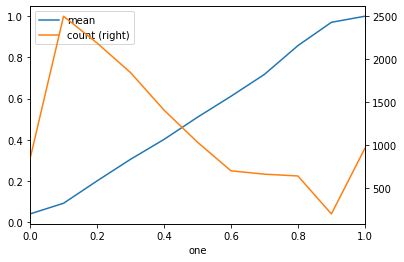

In [288]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [289]:
df_res_grouped

,mean,count
one,,
0.0,0.040189,846
0.1,0.091926,2502
0.2,0.200365,2191
0.3,0.305360,1847
0.4,0.401843,1411
0.5,0.509634,1038
0.6,0.611348,705
0.7,0.717718,666
0.8,0.857364,645


### Prediction

#### Categorical

In [290]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target'].shift(1)
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])
eval_data.loc[:,'pred_class'] = eval_data.loc[:,'pred_class'].shift(1)

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]

eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)

In [291]:
eval_data.groupby('target').mean()

,chng_OPEN,chng_LOW,chng_HIGH,chng_CLOSE,chng_VOL,chng_OPEN_CLOSE,move_strength_abs,move_strength,comp_CLOSE_LOWER_1,comp_CLOSE_HIGH_1,...,roll5m_diff_LOW_HIGH,roll10m_diff_LOW_HIGH,roll20m_diff_LOW_HIGH,roll2m_diff_OPEN_CLOSE,roll3m_diff_OPEN_CLOSE,roll5m_diff_OPEN_CLOSE,roll10m_diff_OPEN_CLOSE,roll20m_diff_OPEN_CLOSE,pred_class,pred_proba
target,,,,,,,,,,,,,,,,,,,,,
0.0,-1.937448,-1.973010,-2.614622,-1.988110,1676.105980,-1.304187,7360.894290,-6557.775965,0.390314,0.913596,...,0.050257,0.049192,0.046306,0.015138,0.011301,0.008501,0.006522,0.005580,0.100473,0.346614
1.0,3.286731,3.178782,4.336716,3.285865,1227.310159,1.469669,6581.396744,4345.613913,0.052526,0.363272,...,0.052833,0.051501,0.049445,-0.012141,-0.006295,-0.001479,0.002302,0.004098,0.574980,0.420269


In [292]:
eval_data.groupby('pred_class').mean()

,chng_OPEN,chng_LOW,chng_HIGH,chng_CLOSE,chng_VOL,chng_OPEN_CLOSE,move_strength_abs,move_strength,comp_CLOSE_LOWER_1,comp_CLOSE_HIGH_1,...,roll5m_diff_LOW_HIGH,roll10m_diff_LOW_HIGH,roll20m_diff_LOW_HIGH,roll2m_diff_OPEN_CLOSE,roll3m_diff_OPEN_CLOSE,roll5m_diff_OPEN_CLOSE,roll10m_diff_OPEN_CLOSE,roll20m_diff_OPEN_CLOSE,target,pred_proba
pred_class,,,,,,,,,,,,,,,,,,,,,
0.0,-1.796785,-1.330907,-1.430090,-0.766235,1860.894155,-0.284917,8193.731460,-3922.371726,0.319315,0.785233,...,0.051448,0.049967,0.047051,0.010364,0.008279,0.006677,0.005608,0.005109,0.226859,0.373044
1.0,4.795533,3.386633,3.808187,2.063090,597.074946,-0.131150,4185.112763,1539.708686,0.112381,0.493061,...,0.050724,0.050356,0.048671,-0.009747,-0.004897,-0.000406,0.003119,0.004766,0.780408,0.379374


In [293]:
eval_data.groupby('pred_proba').mean()

,chng_OPEN,chng_LOW,chng_HIGH,chng_CLOSE,chng_VOL,chng_OPEN_CLOSE,move_strength_abs,move_strength,comp_CLOSE_LOWER_1,comp_CLOSE_HIGH_1,...,roll5m_diff_LOW_HIGH,roll10m_diff_LOW_HIGH,roll20m_diff_LOW_HIGH,roll2m_diff_OPEN_CLOSE,roll3m_diff_OPEN_CLOSE,roll5m_diff_OPEN_CLOSE,roll10m_diff_OPEN_CLOSE,roll20m_diff_OPEN_CLOSE,target,pred_class
pred_proba,,,,,,,,,,,,,,,,,,,,,
0.0,2.666685,-2.121283,1.644078,-4.350399,2153.825334,-5.634287,16201.729547,-15701.007549,0.552009,0.871158,...,0.059036,0.053790,0.047523,0.026875,0.018629,0.012237,0.010080,0.007689,0.489362,0.395981
0.1,0.468592,-1.285579,-0.491613,-2.484942,2721.167442,-2.942688,11135.955973,-10191.962775,0.442846,0.819345,...,0.051329,0.049623,0.046043,0.017475,0.012643,0.009310,0.007423,0.006177,0.315348,0.287370
0.2,-0.309617,-0.587871,-0.866184,-1.238881,2031.404079,-1.164002,4982.988788,-3483.721289,0.303514,0.791876,...,0.048654,0.048123,0.045988,0.009039,0.007649,0.006355,0.005360,0.004902,0.281150,0.255591
0.3,-0.820497,-0.250961,-0.951430,-0.254918,628.423535,-0.060906,2516.226822,495.431177,0.226854,0.747158,...,0.051820,0.051046,0.048122,0.005437,0.005809,0.004849,0.004236,0.004494,0.331348,0.236600
0.4,-0.759478,0.222678,-0.468851,0.705988,1247.605556,0.883803,7089.645056,4841.988845,0.173636,0.669738,...,0.049495,0.048880,0.047580,0.000194,0.001384,0.002500,0.003008,0.003306,0.380142,0.239007
0.5,-0.111734,0.895813,0.320908,1.712379,1768.898650,1.574089,8459.931542,-2238.911099,0.139692,0.622351,...,0.052228,0.051873,0.049846,-0.004764,-0.001726,0.001327,0.003920,0.004603,0.433526,0.287091
0.6,-0.437529,1.015169,0.139940,1.609622,504.717870,1.557299,3197.796911,-2042.097579,0.137589,0.649645,...,0.054269,0.054151,0.051935,-0.003066,-0.000662,0.002744,0.004142,0.005335,0.446809,0.306383
0.7,-0.568797,1.202565,0.513066,2.199881,338.489139,2.075433,4495.671737,4275.384377,0.105105,0.639640,...,0.054547,0.054417,0.052258,-0.004657,-0.001892,0.001757,0.004385,0.005641,0.441441,0.279279
0.8,-0.449932,1.247770,1.130804,3.284750,430.794901,3.161188,4367.521887,3580.546177,0.100775,0.493023,...,0.052378,0.051531,0.050490,-0.010653,-0.005112,-0.000894,0.003100,0.005695,0.558140,0.333333


#### Prediction for couple of papers

In [311]:
res_cols = ['DTYYYYMMDD','TICKER', 'OPEN', 'LOW', 'HIGH','CLOSE', 'target_OPEN_chng',
            'target_HIGH_chng', 'target_CLOSE_chng', 'prob_newHIGH']

res = pd.DataFrame(columns=res_cols)

In [312]:
counter = 0
for p in tqdm(skaner_df_see.ticker.values):
    
    try:
        df = store_dict[p].copy()
        
    except:
        df = prepare_data(p) 
        store_dict[p] = df.copy()
        counter = counter + 1
    
    df = prepare_data(p)
    df = transform_one_paper_ch(df)

    df.loc[:,'pred_class'] = model.predict(df[train_cols])
    df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]
    
    df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
    df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
    df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

    one_res = df.reset_index().loc[:,['DTYYYYMMDD','TICKER','OPEN','LOW','HIGH', 'CLOSE', 
                                      'target', 'pred_class', 'target_OPEN_chng',
                                      'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']].tail(2)

    res = pd.concat([res, pd.DataFrame([[one_res.DTYYYYMMDD.values[0], 
                                   one_res.TICKER.values[0],
                                   one_res.OPEN.values[0],
                                   one_res.LOW.values[0],
                                   one_res.HIGH.values[0],
                                   one_res.CLOSE.values[0],
                                   one_res.target_OPEN_chng.values[0],
                                   one_res.target_HIGH_chng.values[0],
                                   one_res.target_CLOSE_chng.values[0],
                                   one_res.pred_prob.values[0]]], columns=res_cols)])

100%|██████████| 202/202 [00:45<00:00,  4.47it/s]


In [313]:
res.sort_values('prob_newHIGH', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,prob_newHIGH
0,2020-04-08,CYFRPLSAT,24.020,23.700,24.800,24.800,0.725806,4.596774,4.032258,0.997605
0,2020-04-08,NEUCA,431.500,425.000,437.500,437.500,1.257143,1.485714,-0.114286,0.997493
0,2020-04-07,QUANTUM,12.900,12.900,12.900,12.900,0.775194,0.775194,0.775194,0.996880
0,2020-04-08,ENTER,18.000,17.400,18.900,18.900,0.529101,8.465608,5.555556,0.996780
0,2020-04-08,CZTOREBKA,0.270,0.270,0.270,0.270,22.222222,22.222222,22.222222,0.996403
0,2020-04-08,ORCOGROUP,0.840,0.840,0.840,0.840,5.952381,14.047619,14.047619,0.996376
0,2020-04-08,KSGAGRO,1.010,1.010,1.010,1.010,8.910891,8.910891,7.920792,0.995810
0,2020-04-08,ARTIFEX,2.090,2.000,2.510,2.510,15.537849,21.513944,13.147410,0.995733
0,2020-03-30,KBDOM,0.374,0.374,0.374,0.374,20.320856,20.320856,20.320856,0.995228
0,2020-04-08,IZOBLOK,24.500,24.200,25.500,25.500,0.784314,0.784314,0.784314,0.994965


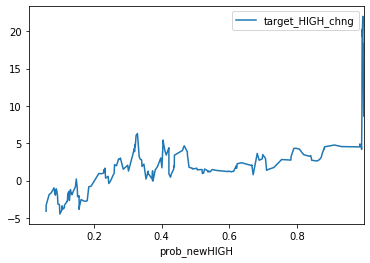

In [314]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


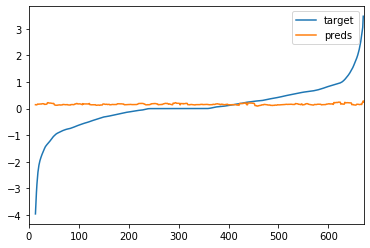

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

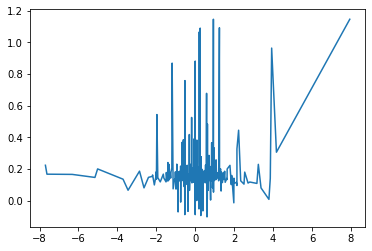

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

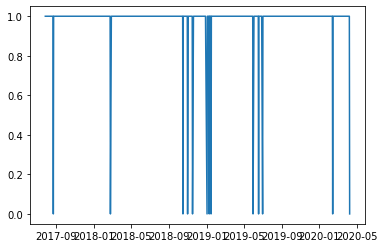

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
